### quantification of viral image segmentations 

requires transformed downsampled points from previous notebook Seg2Pts

In [1]:
import os
import tkinter.filedialog as fdialog
import Neuron_analysis as na
from Neuron_analysis import *
import numpy as np

import pandas as pd
import SimpleITK as sitk

import re

import skimage
from skimage import io

from tqdm import tqdm
import warnings

import plotly.graph_objects as go



In [2]:
in_dir = fdialog.askdirectory(title='Please select the input directory')
# ie: D:\2PT electroporation time\AL066
points_name= fdialog.askopenfilename(title='Selecte the transformed points')

In [3]:
out_dir='D:/Viral_stacks_L5/AL211_1-1200_Results/'
mouse_name=na.find_mousename(in_dir)
out_name=out_dir+mouse_name

In [145]:
#useful functions

def get_pt_natlas(dspoint_name,outdir, full=False):
    '''Read the downsampled points and get the corresponding atlas name
    Feb 2022
    Modified for viral images where points are indices after trailmap segmentation with probability 
    Since some noise will be picked up as axons and cross probability threshold, it is possible for transformed points to have negative value or outside of the brain
    points with negative values any one dimensions are ignored
    '''
    with open(dspoint_name,'r') as output:
        outputpoint= output.readlines()
    
    all_points=[]
    files=os.listdir(outdir)
    atlas=[i for i in files if re.search("atlas.+\.mhd",i)][0]
    atlas_name=os.path.join(outdir, atlas)

    for lines in outputpoint:
        m=re.search("(?:OutputIndexFixed = \[ )([0-9]+ [0-9]+ [0-9]+)", lines)
        if not m:
            print('negative number in one of the dimension, skipped')
            print(f'{lines}')
            pass
        else:
            m=m.groups(0)
            this_line= str(m[0]).split(' ')
            mypoints= [int(stuff) for stuff in this_line]
            all_points.append(mypoints)

    if full== True:
        atlas_name=fullatlas_name
    else: 
        pass
    return all_points, atlas_name

def make_tif_1(all_points, atlas_name, outname):
    ''' Project downsampled points on to a tiff stack, useful for overlaping with brain or template (ie, in imageJ)
    
    Feb 2022
    Modified for viral images where points are indices after trailmap segmentation with probability 
    Since some noise will be picked up as axons and cross probability threshold, it is possible for transformed points to have negative value or outside of the brain
    points outside of the brain are ignored
    
    
    August 18 2021
    Slightly modified version where each pixel will have a value of 1, instead of actual number of points.
    Useful for visualization (ie. max projection) so that all pixel axon or dendrite is equally strong in intensity
       
    
    input: downsampled points in a list containing x y z ordinates as int, directory containing it (this is also the output directory) and whether annotation is axon or not (default True)
    example: [[12, 13, 25],
             [13, 14, 25],...]
    
    output: a tiff stack with the same dimensions of the brain/template/atlas mhd files with downsampled points only
    each point has a value of the number of occurences (since downsampling combines multiple points as one)
    '''
        
    print('Starting to saving tif files..')
    
    atlas= sitk.ReadImage(atlas_name)
    atlas_size=atlas.GetSize()
    svolume=np.zeros(atlas_size)
    #columns, rows, planes
    
    zplanes=[]
    for i in all_points:
        zplanes.append( i[2])
    zplanes=np.unique(zplanes)
    temp=np.zeros(atlas.GetSize()[0:2])
    thepoints=np.asarray(all_points)

    for i in tqdm(zplanes):
        index= thepoints[:,2]==i
        uindex,counts=np.unique(thepoints[index],return_counts=True, axis=0)
        for lines in uindex:
            coord1,coord2=lines[0:2]
            temp[coord1][coord2]= 1
        svolume[:,:,i]=temp #write this in 
        temp=np.zeros(atlas.GetSize()[0:2]) #reset the empty plane after each z
        
    
    coronal_planetmp= np.swapaxes(np.int16(svolume),0,2)
    #for some reason, if just save stuff as tiff, it will save x planes of yz view
    #here we shift the 3rd dimension with the first dimension to obtain xy view
    
    out_name=outname + '.tif'

    io.imsave(out_name,coronal_planetmp)
    return 

def points_atlas_id(all_points, atlas_name):
    ''' 
    Takes in all points (as a list, usually the output of na.refill_section or na.get_pt_natlas ) and formulates a pd structure.
    Input: downsampled points (in transformix compatible format), name of corresponding indicies of endings 
    ouputs: a pandas dataframe with anatomical regions and their corresponding total points count and ending points count, list of atlas ID for each point
    
    '''
                        
    image= sitk.ReadImage(atlas_name)
    atlas =sitk.GetArrayFromImage(image)
        
    points_in_atlas=[int(atlas[i[2], i[1],i[0]]) for i in tqdm(all_points) ]
    #find an ID for all point

    return points_in_atlas

def region_counts (points_in_atlas):
    
    ''' Takes in all points' atlas id, find unique values and their frequency
    returns a pandas dataframe with id, acronym, and their frequency(total counts)
    ''' 
    
    unique, counts = np.unique(points_in_atlas, return_counts=True)
    
    our_regions=atlas_labels.loc[atlas_labels['region_id'].isin (unique)]
    
    id_withcounts=list(zip(unique,counts))

    new_df= pd.DataFrame(id_withcounts, columns=['region_id', 'Total_counts'])
    our_regionWcounts=pd.merge(our_regions, new_df)
    

    return our_regionWcounts.sort_values(by=['Total_counts'])

def sort_by_parent(dataframe,out_name):
    ''' group specific regions based on parent regions (ie, layers in ssp-bfd is grouped together). Sort by parent region with most counts, then within the region sort by layers
    
    ''' 
    
    # merge the data frame with full atlas_labels from the allen based on acronym
    new_pd= na.atlas_labels.merge(dataframe, on= 'acronym')
    # sort by graph order (this accounts for the orderings within parent region, ie. layer 1 to layer 6)
    new_pd.sort_values(by= 'graph_order',axis=0, inplace=True)
    
    # this calls the function above parent_df to group based on parent structure id
    result= parent_df(new_pd)
    
    # get new order
    new_order=result.id.to_numpy()
    # get old order
    old_order= new_pd.parent_structure_id.to_numpy()   
    
    # rearrange specific items to new order
    new_array= np.zeros_like(old_order)
    for i, j in enumerate(new_order):
        new_array[old_order==j]=i
    
    #example: if ids 1,2,4,7,11, 10,8,6 where even numbers belongs to the same parent, then the order becomes 1,4,4,1,1,4,4,4. 
    # Because there are 3 counts of the first group, hence the second group starts counting at 4
    
    #apply the new order
    new_pd['new_order']= new_array
    new_pd.sort_values('new_order', inplace=True)
    new_pd.sort_values(by=['new_order', 'region_id'], ascending=[True, False] ,inplace=True)
    
    out_name=out_name + '_region_with_counts.xls'
    new_pd[::-1].to_excel(out_name,index=None,header=True)
    
    return new_pd[::-1]

def parent_df(df):
    ''' group data frame items by parent id structure
    '''
    grouped_pd=df.groupby(['parent_structure_id'],as_index=False).sum()
    d= {'id': grouped_pd.parent_structure_id.astype(int), 'Total_counts': grouped_pd.Total_counts}
    grouped_pd2= pd.DataFrame(data=d)
    result = pd.merge(grouped_pd2, na.atlas_labels, on=["id"])
    result.sort_values(['Total_counts'], ascending=True, inplace=True)
    # result is the final pd
    return result

def check_points(points_in_atlas):
    '''Checks whether all your points' ID is within the atlas labels
    Input: matching ID of the points (this is the second output from na.make_pd)
    '''
    id_inatlas=[]
    for x in atlas_labels['region_id']:
        intID = int(x)
        id_inatlas.append(intID)

    # need to format this first ourselves,otherwise problematic for 0 and very large numbers (idk why)    

    num_of_zeros = [i for i, x in enumerate(points_in_atlas) if x == 0]
    # find the indices for which carries an id =0
    
    unique_id=set(points_in_atlas)
    
    for id_inbrain in unique_id:
        if id_inbrain not in id_inatlas:
            if id_inbrain==0:
                print(f'There are {len(num_of_zeros)} points with ID= {id_inbrain}, this index is outside of the brain, consider possible suboptimal image registration')
            else: 
                print(id_inbrain,'this index does not exist in allen reference atlas, see https://github.com/ChristophKirst/ClearMap/issues/37')
            warnings.warn('Some points do not have corresponding labels')
    return 

def plot_hist(pd_axon, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''
    y=pd_axon['acronym']
    fig = go.Figure()
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts']/1000, # units now in milimeters
        marker_color='red', #for future, pd_axon['region_id'],
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h')
    )
        
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      width=2000,
                      height=1500, # 1500 for AL066 since too many items
                      showlegend= False,
                      paper_bgcolor='rgba(0,0,0,0)', # transparent background
                      plot_bgcolor='rgba(0,0,0,0)' # transparent background
                     )
    
    fig.update_xaxes(gridcolor='gold')
    
    fig.show()
    # plotly.offline.plot(fig,filename='D:/'+ mousename+'/barplot.html')
    fig.write_html(f"{mousename}.html")

In [75]:
points,atlas_name=get_pt_natlas(points_name,in_dir,full=False)
# reads in the points and get the corresponding atlas(cropped version cus we need to extract the cropped plane from its name)
# adopted from na.get_pt_natlas for single cell tracing


TypeError: expected str, bytes or os.PathLike object, not list

In [42]:
atlas= sitk.ReadImage(atlas_name)
atlas_size=atlas.GetSize()
#columns, rows, planes

In [59]:
# Since segmentation is automatic, not everything picked up is true signal (ie, noise outside of the brain). 
# Some points after transformation have a negative number or value exceeding the dimensions of the atlas image in one of the dimensions.
# get rid of these disquanlified points , since they will not have an brain region index!


trimed_points= []
for item in tqdm(points):
    if item[0] < atlas_size[0] and item[1] < atlas_size[1] and item[2] < atlas_size[2]:
        trimed_points.append(item)
    else:
        print(f'one or more dimensions of points exceeds image dimension of {atlas_size}')
        print(f'{item}')
        pass

  7%|████▉                                                             | 1165314/15572300 [00:00<00:10, 1425367.38it/s]

one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[212, 417, 61]
one or more dimensions of points exceeds image dimension of (228, 411, 288)
[213, 417, 61]

100%|█████████████████████████████████████████████████████████████████| 15572300/15572300 [00:10<00:00, 1467505.97it/s]


In [61]:
# makes tiff for downsampled points
make_tif_1(trimed_points, atlas_name,out_name)


Starting to saving tif files..


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: D:/Viral_stacks_L5/AL211_1-1200_Results/AL211.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [ ]:
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\wraped\ccf_2017_itksnap_labels.csv', sep=',')


In [85]:
points_in_atlas=points_atlas_id(trimed_points,atlas_name)

100%|██████████████████████████████████████████████████████████████████| 15572274/15572274 [00:21<00:00, 712432.51it/s]


In [88]:
#points= np.where(points==0, 844, points_in_atlas) 
# replace id= 0 with 844 (ssp-bfd layer1)

points_in_atlas= np.where(points_in_atlas==800 , 215 , points_in_atlas) 
points_in_atlas= np.where(points_in_atlas==1092 , 215 , points_in_atlas)
# replace id= 800 (subependymal zone) and 1092 (lateral ventricle) with 215(caudoputamen)
# especially for AL131

points_in_atlas= np.where(points_in_atlas==1242, 1296 , points_in_atlas) 
points_in_atlas= np.where(points_in_atlas==1127, 1296 , points_in_atlas)
# replace id= 1242 (optic radiation)  and id= 1127 (auditory radiation) with 1296, stc(a subregion of fiber bundle)
# these are intrinsic issue of the allen atlas, the labels for these regions are wrong

check_points(points_in_atlas)
# check again to see if 0 disappears

There are 40361 points with ID= 0, this index is outside of the brain, consider possible suboptimal image registration


C:\Users\liu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:160: UserWarning: Some points do not have corresponding labels


In [109]:
region_with_counts= region_counts (points_in_atlas)
sorted_pd=sort_by_parent(region_with_counts,out_name)

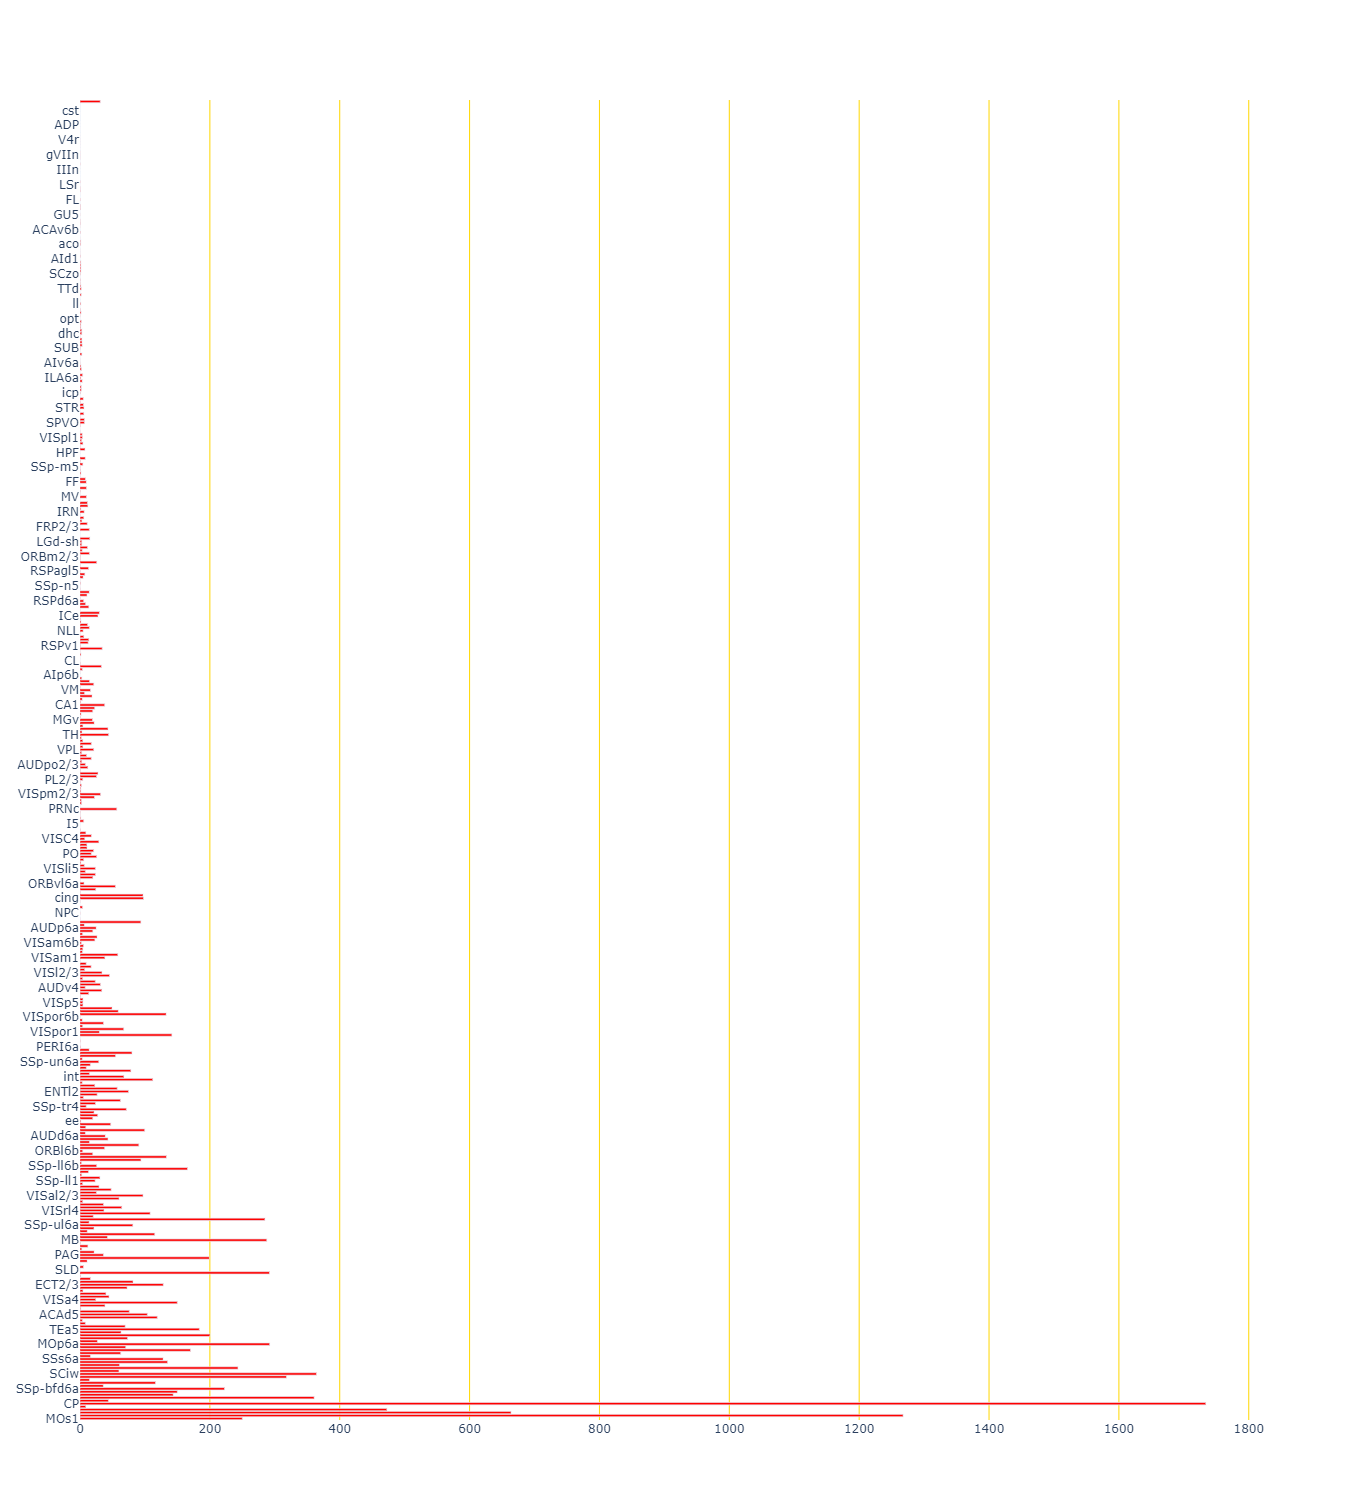

In [146]:
#plot as histogram and save as .html
plot_hist(sorted_pd,'AL211')

In [ ]:
# group item based on parents and save as excel
result= parent_df(sorted_pd)
result.to_excel(f'{out_name}_parent.xls')  

### test area

In [135]:
axon_bar=pd.read_excel(this_mouse[0]).sort_values(by=['Total_counts'])
new_axonpd= na.atlas_labels.merge(axon_bar, on= 'acronym')
new_axonpd.sort_values(by= 'graph_order',axis=0, inplace=True)
result= parent_df(new_axonpd)
result.to_excel(f'{out_name}_parent.xls')  

In [154]:
result= parent_df(sorted_pd)


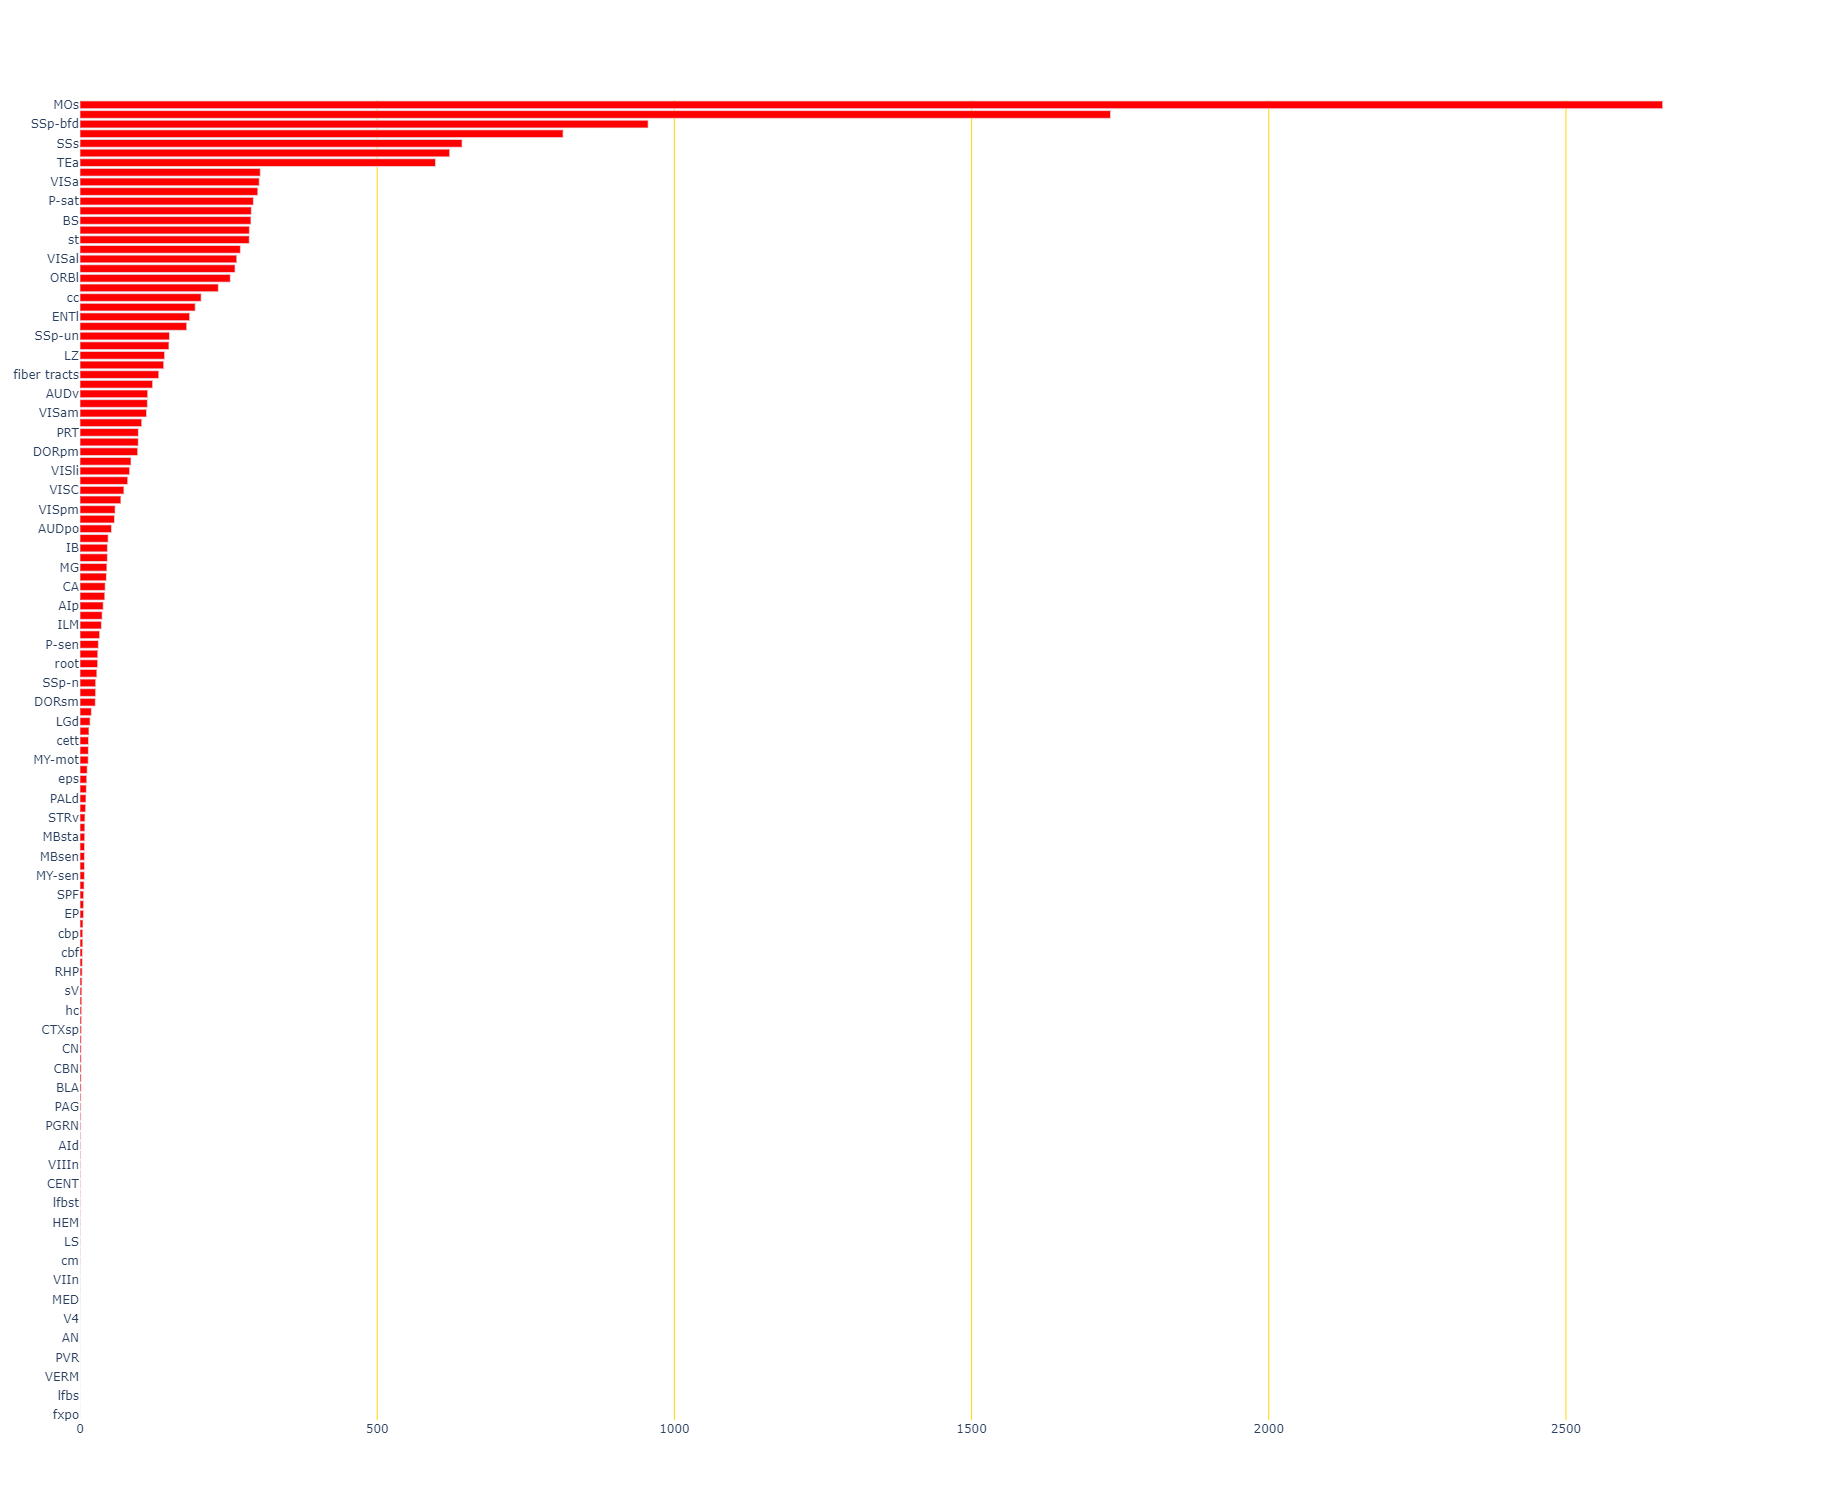

In [156]:
plot_hist(result,'AL211_parent')

In [117]:
result= parent_df(new_pd)
new_order=result.id.to_numpy()
#new_order

In [120]:
new_order

array([      737,       760,       983,       835,       645,       877,
             141,        81,      1017,       278,       145,       809,
             444,       901,       798,       326,       967,       926,
             242,       688,      1073,        73,       896,      1057,
             920,        48,       933,       840,       104,       275,
             938,         8,       795,       302,       295,       589,
             519,       948,       607,       848,       703,       928,
             618,       536,       229,       867,       822,       119,
             960,        44,       752,       726,       942,       623,
             406,       239,       386,       425,       339,       695,
             348,       345,       493,       797,       818,       701,
            1000,       956,       370,       184,       932,      1099,
             170,       731,       864,       894,       353,       879,
             997,         4,      1132,       886, 

In [123]:
old_order= new_pd.parent_structure_id.to_numpy()   

new_array= np.zeros_like(old_order)
for i, j in enumerate(new_order):
    new_array[old_order==j]=i

new_array
# generate new order for the detailed pd

array([  0.,  69.,  69.,  69., 131., 131., 131., 131., 131., 136., 136.,
       136., 136., 136.,  76.,  76.,  76.,  76.,  76.,  76., 134., 134.,
       134., 134., 134., 134., 119., 119., 119., 119., 119., 119.,  61.,
        61.,  61.,  61.,  61.,  61., 123., 123., 123., 123., 123., 123.,
       115., 115., 115., 115., 115., 115., 112., 112., 112., 112., 112.,
       112., 132., 132., 132., 132., 132., 132.,  23.,  23.,  23.,  23.,
        96.,  96.,  96.,  96.,  96.,  96., 117., 117., 117., 117., 117.,
       117., 103., 103., 103., 103., 103., 103.,  92.,  92.,  92.,  92.,
        92.,  92., 106., 106., 106., 106., 106., 106., 120., 120., 120.,
       120., 120., 120., 104., 104., 104., 104., 104., 104., 105., 105.,
       105., 105., 105., 105., 107., 107., 107., 107., 107., 107.,  57.,
        57.,  57.,  57.,  94.,  94.,  94.,  94.,  94.,  94.,  98.,  98.,
        98.,  98.,  98.,  98., 109., 109., 109., 109., 109., 109., 129.,
       129., 129., 129., 129.,  25.,  25.,  25.,  2

In [125]:
new_pd['new_order']= new_array
new_pd.sort_values('new_order', inplace=True)

In [126]:
new_pd.sort_values(by=['new_order', 'region_id'], ascending=[True, False] ,inplace=True)
# sort by new order first (total amount within the same parent id), and then within each substructure, sort by layer 1 to layer 6

In [128]:
new_pd[::-1]

,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name,region_id,Total_counts,new_order
260,656,930.0,"Secondary motor area, layer 1",MOs1,11,1,3,8690,993.0,8,...,NaN,NaN,f,26,4032915713,734881840,Secondary motor area layer 1,503,249936,136.0
123,962,1110.0,"Secondary motor area, layer 2/3",MOs2/3,11,1,3,8690,993.0,8,...,NaN,NaN,f,27,3274108161,734881840,Secondary motor area layer 2/3,504,1267609,136.0
364,767,944.0,"Secondary motor area, layer 5",MOs5,11,1,3,8690,993.0,8,...,NaN,NaN,f,28,4144803096,734881840,Secondary motor area layer 5,505,663827,136.0
433,1021,1117.0,"Secondary motor area, layer 6a",MOs6a,11,1,3,8690,993.0,8,...,NaN,NaN,f,29,3489757563,734881840,Secondary motor area layer 6a,506,472543,136.0
80,1085,1125.0,"Secondary motor area, layer 6b",MOs6b,11,1,3,8690,993.0,8,...,NaN,NaN,f,30,1225271489,734881840,Secondary motor area layer 6b,507,8858,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,342,325.0,Substantia innominata,SI,8,1,3,8690,835.0,6,...,NaN,NaN,f,614,4279866235,734881840,Substantia innominata,806,8,3.0
63,784,663.0,corticospinal tract,cst,8,1,3,8690,983.0,3,...,NaN,NaN,f,1201,2338134602,734881840,corticospinal tract,1154,7,2.0
24,102,578.0,nigrostriatal tract,nst,8,1,3,8690,760.0,4,...,NaN,NaN,f,1222,1908794680,734881840,nigrostriatal tract,1236,1,1.0
443,436,478.0,columns of the fornix,fx,10,1,3,8690,737.0,6,...,NaN,NaN,f,1253,2234311931,734881840,columns of the fornix,1185,1,0.0
